In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd

from datasets import (load_cyc_2008,
                   load_Y2H_union_25,
                   load_subcellular_location,
                   load_kegg_pathway_genes,
                   load_gi_pcc_values,
                   load_cs_pcc_values,
                   load_ge_pcc_values,
                   load_gi_psn,
                   load_cs_psn,
                   load_ge_psn,
                   )
from utils import format_network, generate_random_networks
from plotting import COLOR_Y2H, savefig

In [2]:
pd.set_option('display.max_columns', 40)
mpl.rcParams['font.size'] = 7.
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['savefig.dpi'] = 500

In [3]:
yi2 = load_Y2H_union_25(remove_homodimers=True)
yi2 = yi2.loc[yi2['YeRI'], :]
complexes = load_cyc_2008()
subcell = load_subcellular_location()
pathways = load_kegg_pathway_genes()
yi2 = format_network(yi2,
                             'igraph',
                             id_type='orf_name')
rand_nw = generate_random_networks(yi2, n=1000)

In [4]:
def co_membership_fraction(nw, gene_groups):
    """
    
    Args:
        nw (igraph.Graph)
        
    """
    n = 0
    for edge in nw.es:
        for members in gene_groups:
            if nw.vs[edge.source]['name'] in members and nw.vs[edge.target]['name'] in members:
                n += 1
                break
    return n / len(nw.es)


def co_localization_fraction(nw):
    """
    
    Args:
        nw (igraph.Graph)
        
    """
    n = 0
    for edge in nw.es:
        a = nw.vs[edge.source]['name']
        b = nw.vs[edge.target]['name']
        if a not in subcell.index or b not in subcell.index:
            continue
        locs_a = subcell.columns[subcell.loc[a, :]]
        locs_b = subcell.columns[subcell.loc[b, :]]
        if len(locs_a.intersection(locs_b)) > 0:
            n += 1
    return n / len(nw.es)

In [5]:
obs_complex_f = co_membership_fraction(yi2, complexes.values())
rand_complex_f = [co_membership_fraction(nw, complexes.values()) for nw in rand_nw]
obs_pathway_f = co_membership_fraction(yi2, pathways.values())
rand_pathway_f = [co_membership_fraction(nw, pathways.values()) for nw in rand_nw]
obs_loc_f = co_localization_fraction(yi2)
rand_loc_f = [co_localization_fraction(nw) for nw in rand_nw]

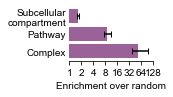

In [6]:
xs = [obs_loc_f / np.mean(rand_loc_f),
      obs_pathway_f / np.mean(rand_pathway_f),
      obs_complex_f / np.mean(rand_complex_f)]
one_sigma = 0.6827
q_low = (1 - one_sigma) / 2
q_high = 0.5 + one_sigma / 2
lims = [[obs_loc_f / np.quantile(rand_loc_f, q_high),
         obs_pathway_f / np.quantile(rand_pathway_f, q_high),
         obs_complex_f / np.quantile(rand_complex_f, q_high)],
        [obs_loc_f / np.quantile(rand_loc_f, q_low),
         obs_pathway_f / np.quantile(rand_pathway_f, q_low),
         obs_complex_f / np.quantile(rand_complex_f, q_low)]]
errs = [[x - low for x, low in zip(xs, lims[0])],
        [high - x for x, high in zip(xs, lims[1])]]

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(1.5, 1)
labels = ['Subcellular\ncompartment',
         'Pathway',
         'Complex']
ax.barh(labels,
        xs,
        color=COLOR_Y2H)
ax.errorbar(y=labels,
            x=xs,
            xerr=errs,
            fmt='none',
            color='black',
            capsize=3)

ax.set_xscale('log', base=2, nonpositive='clip')
ax.set_xticks([2**i for i in range(0, 8)])
ax.set_xticklabels([str(2**i) for i in range(0, 8)])
ax.invert_yaxis()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_tick_params(length=0)
ax.set_xlabel('Enrichment over random')
savefig('YI2_co_membership_enrichment')

In [7]:
def co_localization_fraction_single(nw, compartment):
    """
    
    Args:
        nw (igraph.Graph)
        
    """
    n = 0
    for edge in nw.es:
        a = nw.vs[edge.source]['name']
        b = nw.vs[edge.target]['name']
        if a not in subcell.index or b not in subcell.index:
            continue
        if subcell.at[a, compartment] and subcell.at[b, compartment]:
            n += 1
    return n / len(nw.es)

compartments = subcell.sum().sort_values(ascending=False).index
obs_single_loc = [co_localization_fraction_single(yi2, c) for c in compartments]
rand_single_loc = [[co_localization_fraction_single(nw, c) for nw in rand_nw] for c in compartments]

/var/folders/4f/st3pbvs10sd68jl3b4p861h80000gn/T/ipykernel_30218/1292266236.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  errs = [[obs / np.mean(rand) - obs / np.quantile(rand, q_high) for obs, rand in zip(obs_single_loc, rand_single_loc)],


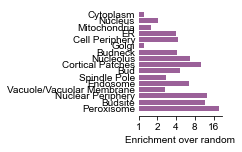

In [8]:
each_comp_enrich = [obs / np.mean(rand) for obs, rand in zip(obs_single_loc, rand_single_loc)]
errs = [[obs / np.mean(rand) - obs / np.quantile(rand, q_high) for obs, rand in zip(obs_single_loc, rand_single_loc)],
        [obs / (np.quantile(rand, q_low) + 0.1 / len(yi2.es)) - obs / np.mean(rand) for obs, rand in zip(obs_single_loc, rand_single_loc)]]





fig, ax = plt.subplots(1, 1)
fig.set_size_inches(1.5, 2.)
ax.barh(compartments,
        each_comp_enrich,
        color=COLOR_Y2H)
# error bars are problematic because you get to 0 expected pairs so enrichment is inf
#ax.errorbar(y=compartments,
#            x=each_comp_enrich,
#            xerr=errs,
#            fmt='none',
#            color='black',
#            capsize=3)

ax.set_xscale('log', base=2, nonpositive='clip')
ax.set_xticks([2**i for i in range(0, 5)])
ax.set_xticklabels([str(2**i) for i in range(0, 5)])
ax.invert_yaxis()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_tick_params(length=0)
ax.set_xlabel('Enrichment over random')
savefig('YI2_compartment_enrichment')

In [9]:
rand_nw_df = [format_network(rnd, 'pandas', id_type='orf_name') for rnd in rand_nw]
yi2_df = format_network(yi2, 'pandas', id_type='orf_name')
gi_pcc = load_gi_pcc_values()
cs_pcc = load_cs_pcc_values()
ge_pcc = load_ge_pcc_values()
gi = load_gi_psn()
chemo = load_cs_psn()
coexp = load_ge_psn()
sga_space = set(gi_pcc.index)
chemo_space = set(cs_pcc.index)
coexp_space = set(ge_pcc.index)
gi['PCC'] = gi.index.map(gi_pcc['PCC'])
chemo['PCC'] = chemo.index.map(cs_pcc['PCC'])
coexp['PCC'] = coexp.index.map(ge_pcc['PCC'])

In [10]:
qs = (0.0, 0.9, 0.99)
q_names = ('_1pct', '_0.1pct', '_0.01pct')
psn_specs = [
    (gi,    set(sga_space),   "GI_PSN"),
    (chemo, set(chemo_space), "CS_PSN"),
    (coexp, set(coexp_space), "GE_PSN"),
]

def make_code_map(psn: pd.DataFrame, qs=(0.0, 0.9, 0.99)) -> pd.Series:
    """Return Series: index=node_id, value=uint8 code in {0,1,2,3}."""
    pcc = psn["PCC"]
    thr = pcc.quantile(qs).to_numpy()
    p = pcc.to_numpy()

    # 0, 1, 2, 3 where higher means in more stringent quantile bins
    code = (p >= thr[0]).astype(np.uint8)
    code += (p >= thr[1]).astype(np.uint8)
    code += (p >= thr[2]).astype(np.uint8)

    return pd.Series(code, index=psn.index)

all_nws = [yi2_df] + rand_nw_df
big = pd.concat(all_nws, keys=np.arange(len(all_nws)), names=["nw_id", "edge_id"])
big["orf_name_a"] = big["orf_name_a"].astype("category")
big["orf_name_b"] = big["orf_name_b"].astype("category")
edge_ids = big.index.get_level_values("edge_id")
psn_pre = [(name, space_set, make_code_map(psn, qs)) for psn, space_set, name in psn_specs]

for psn_name, space_set, code_map in psn_pre:
    in_space = edge_ids.isin(space_set)
    code = code_map.reindex(edge_ids).fillna(0).to_numpy(np.uint8)
    big["in_" + psn_name + q_names[0]] = np.where(in_space, code >= 1, np.nan)
    big["in_" + psn_name + q_names[1]] = np.where(in_space, code >= 2, np.nan)
    big["in_" + psn_name + q_names[2]] = np.where(in_space, code >= 3, np.nan)

out = [big.xs(i, level="nw_id") for i in range(len(all_nws))]
yi2_df = out[0]
rand_nw_df = out[1:]


0.2357022603955158
0.04569116623849539
0.039746431675858215
0.05954913341754136
0.04096159602595202
0.2357022603955158


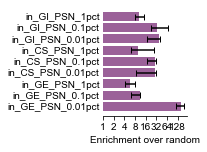

In [11]:
psns = ['in_' + psn + q for psn in ['GI_PSN', 'CS_PSN', 'GE_PSN'] for q in ['_1pct', '_0.1pct', '_0.01pct']]
xs = [yi2_df[psn].mean() / np.mean([rnd[psn].mean() for rnd in rand_nw_df]) for psn in psns]
one_sigma = 0.6827
q_low = (1 - one_sigma) / 2
q_high = 0.5 + one_sigma / 2

def combo_err(psn, q):
    obs = yi2_df[psn].mean()
    mean_fold = obs / np.mean([rnd[psn].mean() for rnd in rand_nw_df])
    q_rnd = np.quantile([rnd[psn].mean() for rnd in rand_nw_df], q)
    if q_rnd > 0:
        return obs / q_rnd
    else:
        count = sum([rnd[psn].sum() for rnd in rand_nw_df])
        p_err = count ** 0.5 / count
        print(p_err)
        if q > 0.5:
            return mean_fold * (1 - p_err)
        else:
            return mean_fold * (1 + p_err)
    

#lims = [[yi2_df[psn].mean() / np.quantile([rnd[psn].mean() for rnd in rand_nw_df], q_high) for psn in psns],
#        [yi2_df[psn].mean() / np.quantile([rnd[psn].mean() for rnd in rand_nw_df], q_low) for psn in psns]]

lims = [[combo_err(psn, q_high) for psn in psns],
        [combo_err(psn, q_low) for psn in psns]]

errs = [[x - low for x, low in zip(xs, lims[0])],
        [high - x for x, high in zip(xs, lims[1])]]

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=1.5, h=2)
labels = psns
ax.barh(labels,
        xs,
        color=COLOR_Y2H)
ax.errorbar(y=labels,
            x=xs,
            xerr=errs,
            fmt='none',
            color='black',
            capsize=3)

ax.set_xscale('log', base=2)#, nonpos='clip')
ax.set_xticks([2**i for i in range(0, 8)])
ax.set_xticklabels([str(2**i) for i in range(0, 8)])
ax.invert_yaxis()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_tick_params(length=0)
ax.set_xlabel('Enrichment over random')
savefig('YI2_PSN_enrichment')